<a href="https://colab.research.google.com/github/rupeshthapa123/NotebookProject/blob/main/Lab7TimeSeries_RupeshThapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries

### Timeseries is any data collected via measurements at a regular interval of the time. Some examples of timeseries data are daily price of a stock, hourly electricity consumption, or weekly sales, local weather, seismic activity e.t.c. and Timeseries requires knowledge of the system dynamic.


### In this Lab we are going to predict a temperature 24 hours in the future given a timeseries data from Jena Dataset with 420,551 climate samples taken every 10 minutes between 2009-2016.

### Here, we will be comparing three different models for prediction and the models are dense network, convolutional network and recurrent LSTM.

## First we are downloading and exploring the dataset and importing all the necessary libraries

In [ ]:
# Downloading the dataset and unzipping it
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-07-11 22:40:40--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.131.240, 52.216.213.176, 54.231.161.16, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.131.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  45.2MB/s    in 0.3s    

2024-07-11 22:40:41 (45.2 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
# Importing necessary libraries
# Reading the file and extracting data
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


## Data Ingestion

Separating the features(measurements) from the output quantity.

In [ ]:
# Initializing arrays for temperature and other raw data
import numpy as np
temperature = np.zeros((len(lines) ,))
raw_data = np.zeros((len(lines), len(header) -1))

# Filling the arrays with data
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",") [1:]]
  temperature[i] = values[1]
  raw_data[i, :]= values[:]

## Visualizing for discovering time patterns

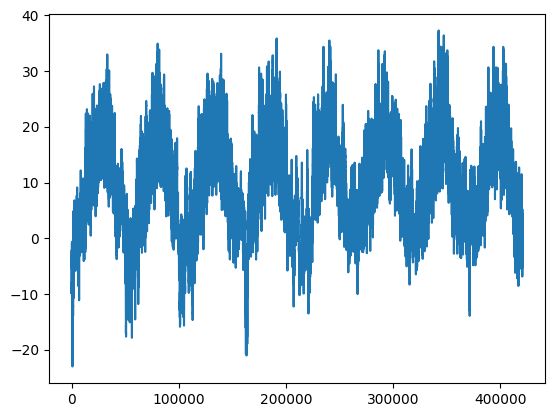

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

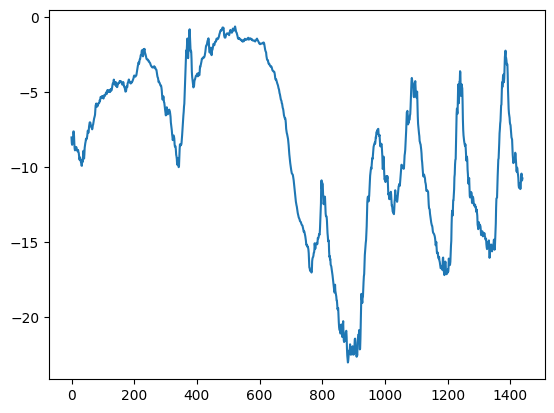

In [ ]:
# Zooming in on the first 1440 data points (10 days)
plt.plot(range(1440), temperature[:1440])

## Splitting the data over 50% training, 25% validation and 25% testing

In [ ]:
# Splitting the data into training, validation, and testing sets
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [ ]:
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Data Preparation

Mean/Standard Deviation only from training dataset is taken.

In [ ]:
# Standardizing the data using the training set statistics
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

## Data Sampling

To extract features from days
in the past and target in the
future use the function
timeseries_dataset_from_array()

In [ ]:
import tensorflow
from tensorflow import keras
# Preparing the timeseries dataset
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 -1)
batch_size = 128

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples)

## Model 1  that is Dense Network is used in the above data sampling

In [ ]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                   save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
1637/1637 [==============================] - 51s 31ms/step - loss: 10.5024 - mae: 2.5217 - val_loss: 10.8827 - val_mae: 2.6078
Epoch 2/10
1637/1637 [==============================] - 47s 29ms/step - loss: 8.1027 - mae: 2.2406 - val_loss: 11.3410 - val_mae: 2.6628
Epoch 3/10
1637/1637 [==============================] - 50s 30ms/step - loss: 7.5168 - mae: 2.1599 - val_loss: 10.9129 - val_mae: 2.6060
Epoch 4/10
1637/1637 [==============================] - 48s 29ms/step - loss: 7.1676 - mae: 2.1102 - val_loss: 12.7737 - val_mae: 2.8239
Epoch 5/10
1637/1637 [==============================] - 53s 32ms/step - loss: 6.9272 - mae: 2.0735 - val_loss: 11.1247 - val_mae: 2.6318
Epoch 6/10
1637/1637 [==============================] - 47s 28ms/step - loss: 6.7464 - mae: 2.0462 - val_loss: 11.9484 - val_mae: 2.7343
Epoch 7/10
1637/1637 [==============================] - 48s 29ms/step - loss: 6.5908 - mae: 2.0233 - val_loss: 11.7544 - val_mae: 2.7041
Epoch 8/10
1637/1637 [==================

## Plot for the fully connected dense network

<function matplotlib.pyplot.show(close=None, block=None)>

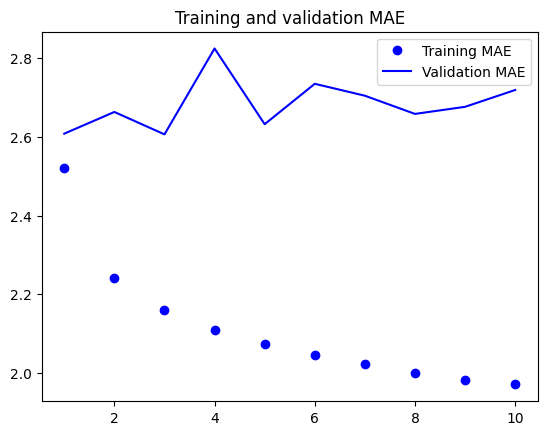

In [ ]:
# Plotting training and validation MAE for Dense Network
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss=history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show

## Convolutional Network

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history2 = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
1637/1637 [==============================] - 89s 53ms/step - loss: 20.1677 - mae: 3.5087 - val_loss: 15.5215 - val_mae: 3.1141
Epoch 2/10
1637/1637 [==============================] - 84s 51ms/step - loss: 14.5225 - mae: 3.0192 - val_loss: 15.6147 - val_mae: 3.1420
Epoch 3/10
1637/1637 [==============================] - 80s 49ms/step - loss: 13.3469 - mae: 2.8896 - val_loss: 14.1625 - val_mae: 2.9687
Epoch 4/10
1637/1637 [==============================] - 83s 50ms/step - loss: 12.5629 - mae: 2.8007 - val_loss: 14.1541 - val_mae: 2.9574
Epoch 5/10
1637/1637 [==============================] - 83s 50ms/step - loss: 11.8998 - mae: 2.7229 - val_loss: 15.4389 - val_mae: 3.0813
Epoch 6/10
1637/1637 [==============================] - 85s 52ms/step - loss: 11.2460 - mae: 2.6485 - val_loss: 17.3482 - val_mae: 3.3050
Epoch 7/10
1637/1637 [==============================] - 82s 50ms/step - loss: 10.7158 - mae: 2.5863 - val_loss: 17.3904 - val_mae: 3.2716
Epoch 8/10
1637/1637 [============

## Plot the history of convolutional network

<function matplotlib.pyplot.show(close=None, block=None)>

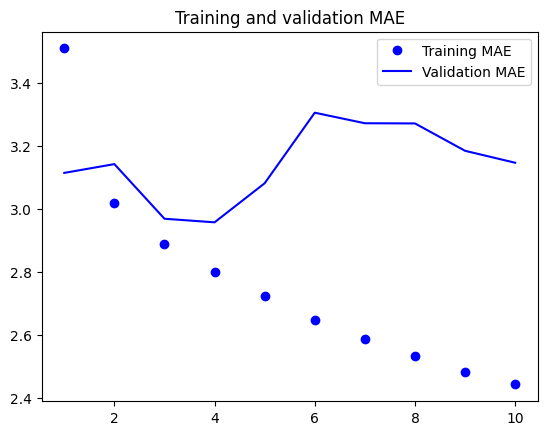

In [ ]:
# Plotting training and validation MAE for Convolutional Network
import matplotlib.pyplot as plt
loss = history2.history["mae"]
val_loss=history2.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show

## Long Short Term Memory Network
### A type of Recurrent network that saves information for later
### Prevents older signals gradually vanish during processing inside the layers

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                   save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history3 = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
1637/1637 [==============================] - 157s 94ms/step - loss: 27.7168 - mae: 3.7504 - val_loss: 9.5797 - val_mae: 2.3980
Epoch 2/10
1637/1637 [==============================] - 153s 93ms/step - loss: 9.7957 - mae: 2.4396 - val_loss: 9.3091 - val_mae: 2.3660
Epoch 3/10
1637/1637 [==============================] - 142s 87ms/step - loss: 9.2208 - mae: 2.3646 - val_loss: 9.2872 - val_mae: 2.3674
Epoch 4/10
1637/1637 [==============================] - 139s 85ms/step - loss: 8.8585 - mae: 2.3140 - val_loss: 9.3378 - val_mae: 2.3824
Epoch 5/10
1637/1637 [==============================] - 141s 86ms/step - loss: 8.4750 - mae: 2.2654 - val_loss: 9.2811 - val_mae: 2.3715
Epoch 6/10
1637/1637 [==============================] - 141s 86ms/step - loss: 8.1669 - mae: 2.2272 - val_loss: 9.4087 - val_mae: 2.3948
Epoch 7/10
1637/1637 [==============================] - 138s 84ms/step - loss: 7.9603 - mae: 2.1973 - val_loss: 9.5368 - val_mae: 2.4119
Epoch 8/10
1637/1637 [==================

## Plot of LSTM to see the MAE of training and validation differences

<function matplotlib.pyplot.show(close=None, block=None)>

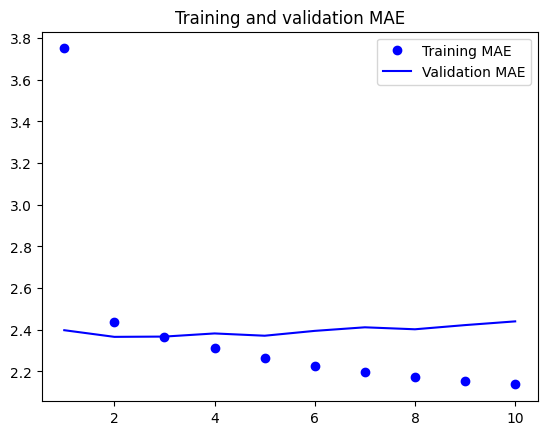

In [ ]:
# Plotting training and validation MAE for LSTM Network
import matplotlib.pyplot as plt
loss = history3.history["mae"]
val_loss=history3.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show

## Conclusion

Based on the Mean Absolute Error (MAE) observed during testing, the LSTM network is generally the best option for this dataset due to its ability to capture long-term dependencies, which are crucial for timeseries data like climate measurements. However, if computational resources are limited or faster inference is required, the convolutional network provides a good balance between performance and efficiency.